In [42]:
import pandas as pd

In [43]:
# Load model
import pickle


def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


model = load_model(filename="../model/model.pkl")
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km_total',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'la...
                                                   'last_11_months_sales',
                                                   'last_12_months_sales',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['brand_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style',
                                                   'dealer_region'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=1, max_depth=10,
                                n_estimators=300, num_leaves=15,
                                random_state=42, subsample=0.8, verbose=-1))])

In [44]:
# Load completely transformed data with best sellers added
file_path = "../data/processed/vehicle_sales_model_ready_with_bestseller.parquet"
df = pd.read_parquet(file_path)

# Rename monthly_best_seller to monthly_best_seller_actual
df = df.rename(columns={"monthly_best_seller": "monthly_best_seller_actual"})

print(df.columns)
df.head(3)

Index(['price', 'mileage_km_total', 'crash_test_score', 'body_style', 'color',
       'transmission', 'dealer_region', 'brand_model', 'engine', 'year',
       'month', 'current_month_sales', 'last_1_months_sales',
       'last_2_months_sales', 'last_3_months_sales', 'last_4_months_sales',
       'last_5_months_sales', 'last_6_months_sales', 'last_7_months_sales',
       'last_8_months_sales', 'last_9_months_sales', 'last_10_months_sales',
       'last_11_months_sales', 'last_12_months_sales',
       'monthly_best_seller_actual'],
      dtype='object')


,price,mileage_km_total,crash_test_score,body_style,color,transmission,dealer_region,brand_model,engine,year,...,last_4_months_sales,last_5_months_sales,last_6_months_sales,last_7_months_sales,last_8_months_sales,last_9_months_sales,last_10_months_sales,last_11_months_sales,last_12_months_sales,monthly_best_seller_actual
0,26000,68468,4,SUV,Black,Auto,Middletown,Ford-Expedition,Double Overhead Camshaft,2022,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
1,19000,64053,3,SUV,Black,Auto,Aurora,Dodge-Durango,Double Overhead Camshaft,2022,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0
2,31500,24942,5,Passenger,Red,Manual,Greenville,Cadillac-Eldorado,Overhead Camshaft,2022,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1


In [45]:
# Get test data (the one used for models evaluation that models were not trained on)
test_cond = (df["year"] == 2023) & (df["month"] >= 10)
test_df = df[test_cond]
X_test = test_df.drop(columns=["monthly_best_seller_actual"])
y_test = test_df["monthly_best_seller_actual"]

In [46]:
# Make predictions and add them as a new column
test_df["monthly_best_seller_predicted"] = model.predict(X_test)

print("Actual best sellers:", len(test_df[test_df["monthly_best_seller_actual"] == 1]))
print("Predicted best sellers:", len(test_df[test_df["monthly_best_seller_predicted"] == 1]))

test_df[
    ["brand_model", "monthly_best_seller_actual", "monthly_best_seller_predicted"]
].head()

Actual best sellers: 277
Predicted best sellers: 421


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/0c/3b2dkdy1209_gm_z1sjrc81c0000gn/T/ipykernel_21373/3369804529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["monthly_best_seller_predicted"] = model.predict(X_test)


,brand_model,monthly_best_seller_actual,monthly_best_seller_predicted
19140,Chevrolet-Cavalier,0,0
19141,Dodge-Viper,0,0
19142,Lexus-GS300,0,0
19143,Lincoln-Town car,0,0
19144,Toyota-4Runner,0,0


At first glance, the model seems to be doing well, but let's check the accuracy.

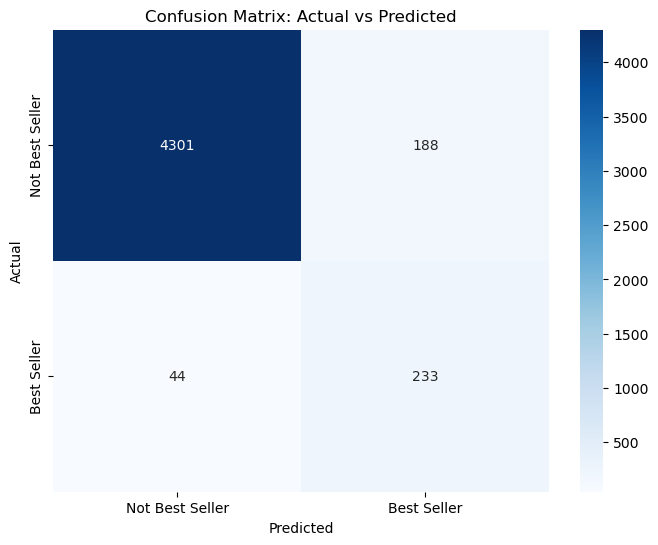

Accuracy:   0.95132186319765
Precision:  0.5534441805225653
Recall:     0.8411552346570397
F1 Score:   0.667621776504298


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Extract actual and predicted values
y_actual = test_df["monthly_best_seller_actual"]
y_predicted = test_df["monthly_best_seller_predicted"]

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_actual, y_predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Best Seller', 'Best Seller'],
            yticklabels=['Not Best Seller', 'Best Seller'])
plt.title('Confusion Matrix: Actual vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Print classification stats
print("Accuracy:  ", accuracy_score(y_actual, y_predicted))
print("Precision: ", precision_score(y_actual, y_predicted))
print("Recall:    ", recall_score(y_actual, y_predicted))
print("F1 Score:  ", f1_score(y_actual, y_predicted))

/var/folders/0c/3b2dkdy1209_gm_z1sjrc81c0000gn/T/ipykernel_21373/3941165894.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['brand'] = test_df['brand_model'].str.split().str[0]


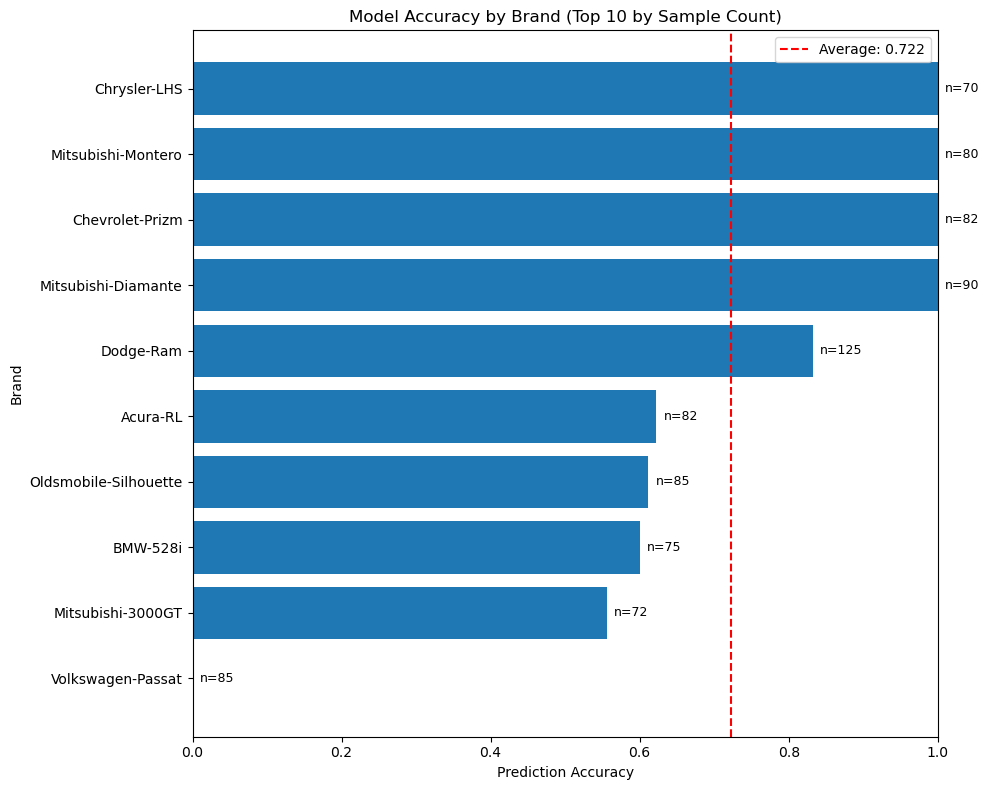

Top 10 brands by sample count:
                brand  accuracy  count
    Volkswagen-Passat  0.000000     85
    Mitsubishi-3000GT  0.555556     72
             BMW-528i  0.600000     75
Oldsmobile-Silhouette  0.611765     85
             Acura-RL  0.621951     82
            Dodge-Ram  0.832000    125
  Mitsubishi-Diamante  1.000000     90
      Chevrolet-Prizm  1.000000     82
   Mitsubishi-Montero  1.000000     80
         Chrysler-LHS  1.000000     70


In [48]:
#Here we visualize the accuracy of the model by brand and find some startling things! UH OH!

import matplotlib.pyplot as plt
import pandas as pd

# Extract brand from brand_model (assuming format like "Toyota Camry")
test_df['brand'] = test_df['brand_model'].str.split().str[0]

# Calculate accuracy for each brand
brand_metrics = []
for brand in test_df['brand'].unique():
    brand_data = test_df[test_df['brand'] == brand]
    accuracy = (brand_data['monthly_best_seller_actual'] == 
               brand_data['monthly_best_seller_predicted']).mean()
    brand_metrics.append({
        'brand': brand, 
        'accuracy': accuracy, 
        'count': len(brand_data)
    })

brand_df = pd.DataFrame(brand_metrics)

# Filter for brands with at least 5 samples and get top 10 by sample count
brand_df = brand_df[brand_df['count'] >= 5]
top_10_brands = brand_df.nlargest(10, 'count').sort_values('accuracy')

# Create horizontal bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(top_10_brands['brand'], top_10_brands['accuracy'])
plt.xlabel('Prediction Accuracy')
plt.ylabel('Brand')
plt.title('Model Accuracy by Brand (Top 10 by Sample Count)')

# Add sample count labels on bars
for i, (bar, row) in enumerate(zip(bars, top_10_brands.itertuples())):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'n={row.count}', va='center', fontsize=9)

# Add average accuracy line
avg_accuracy = top_10_brands['accuracy'].mean()
plt.axvline(x=avg_accuracy, color='red', linestyle='--', 
            label=f'Average: {avg_accuracy:.3f}')
plt.legend()
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

print("Top 10 brands by sample count:")
print(top_10_brands[['brand', 'accuracy', 'count']].to_string(index=False))

In [49]:
#We find that it is overfitting some models and underfitting others, 
# most critically our number four car for volume, the Volkswagen Passat
# View top brand_model counts
model_counts = df['brand_model'].value_counts()
model_counts_df = model_counts.reset_index()
model_counts_df.columns = ['brand_model', 'count']

# Show top 10 and bottom 10 models
display(model_counts_df.head(10))


,brand_model,count
0,Mitsubishi-Diamante,418
1,Oldsmobile-Silhouette,411
2,Chevrolet-Prizm,411
3,Volkswagen-Passat,391
4,Dodge-Ram Pickup,383
5,Volkswagen-Jetta,382
6,Acura-RL,372
7,Lexus-LS400,354
8,Chrysler-LHS,330
9,Audi-A6,329


In [50]:
# Check what the model is actually predicting for Passat
passat_data = test_df[test_df['brand'] == 'Volkswagen-Passat']
print("Passat predictions:")
print(passat_data[['monthly_best_seller_actual', 'monthly_best_seller_predicted']].value_counts())

Passat predictions:
monthly_best_seller_actual  monthly_best_seller_predicted
0                           1                                62
1                           0                                23
Name: count, dtype: int64


Model Weakness

Volkswagen Passat is the 4th highest volume brand but has 0% prediction accuracy.
It gets predicted wrong in both directions: 62 times predicted as top 3 when it wasn't, 23 times predicted as not top 3 when it was.

It is actually the hardest car to predict because if moves between our models binary of "in the top three" or "not in the top three".

This is an issue because our predictions totally wrong on one of the highest-volume brands so we need to do some investigation and fine tuning which likely require a change in logic. I think a little threshold tuning is a good start. 
